In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
config = get_config()
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 1024
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [7]:
import pandas as pd
def get_drift_files_nonfull(config, root_dir ):
    ts_type = f"QuadSinHF"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/QuadSinHFLessData/"
    true_files = []
    local_files = []
    mses = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
            elif "bwidx" in file:
                mses_full = pd.read_parquet(root_nadaraya_dir+file)
                print(mses_full)
                mses.append(mses_full)
    mses = pd.concat(mses).sort_values("bw", axis=0)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws, mses

         bw       mse
37  6.16595  0.770139
            bw       mse
52  398.107171  0.774559
          bw       mse
15  0.018211  0.075937
          bw       mse
19  0.055348  0.209062
          bw       mse
33  2.344229  0.746196
          bw       mse
35  3.801894  0.763179
           bw       mse
40  12.589254  0.773488
          bw       mse
36  4.841724  0.767449
          bw       mse
23  0.168214  0.497229
          bw       mse
29  0.891251  0.642802
             bw      mse
58  6309.573445  0.77456
         bw       mse
9  0.003437  0.419089
          bw       mse
13  0.010446  0.134225
        bw       mse
54  1000.0  0.774559
           bw       mse
41  15.848932  0.773883
          bw       mse
20  0.073079  0.341246
         bw       mse
5  0.001131  1.279783
          bw       mse
30  1.135011  0.679399
            bw       mse
53  630.957344  0.774559
           bw       mse
46  50.118723  0.774492
         bw       mse
0  0.000282  5.824999
            bw       mse
50 

Text(0.5, 1.0, 'Minimum MSE is (0.06668907, 16)')

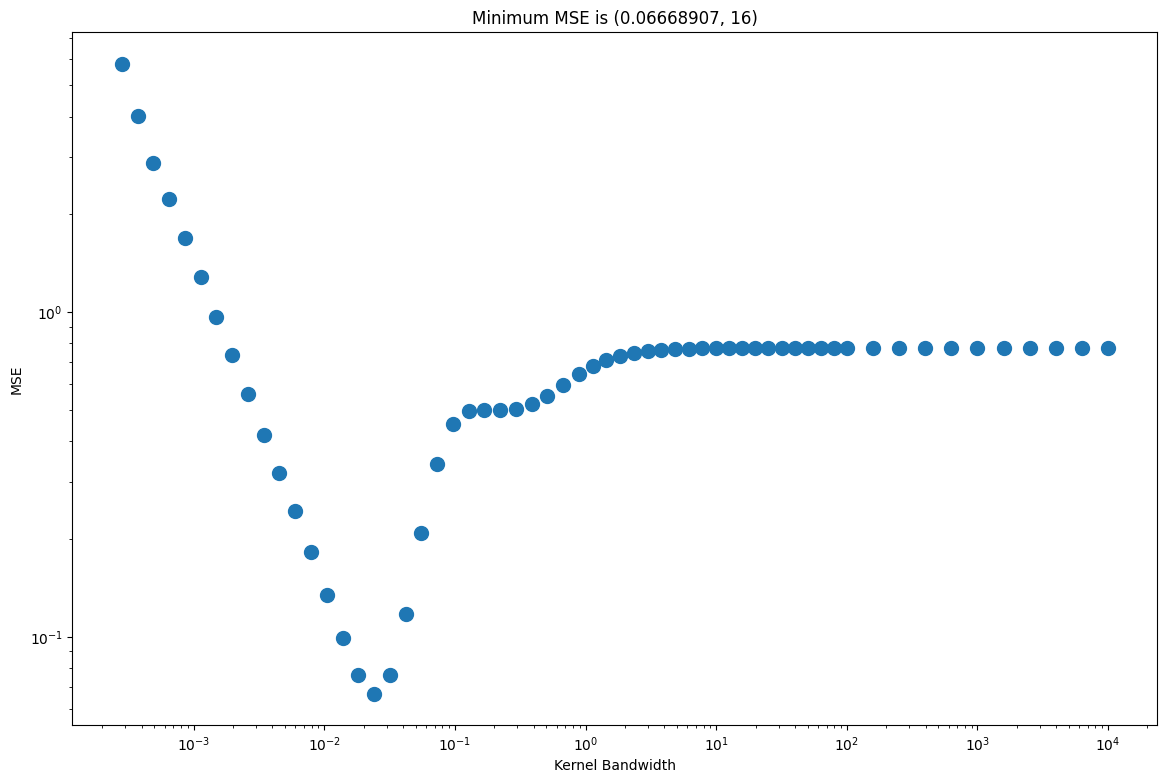

In [8]:
config = get_config()
true_files, local_files, bws, mses = get_drift_files_nonfull(config=config, root_dir=root_dir)
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("MSE")
ax.set_xlabel("Kernel Bandwidth")
ax.set_title(f"Minimum MSE is {mses.iloc[np.argmin(mses.mse), 1], np.argmin(mses.mse)}")

In [9]:
print(mses.sort_index())

              bw       mse
0       0.000282  5.824999
1       0.000372  4.010081
2       0.000491  2.873076
3       0.000649  2.234272
4       0.000857  1.687069
5       0.001131  1.279783
6       0.001493  0.966071
7       0.001972  0.737088
8       0.002603  0.557871
9       0.003437  0.419089
10      0.004538  0.318617
11      0.005992  0.243549
12      0.007912  0.182763
13      0.010446  0.134225
14      0.013793  0.098819
15      0.018211  0.075937
16      0.024046  0.066689
17      0.031749  0.076018
18      0.041919  0.117574
19      0.055348  0.209062
20      0.073079  0.341246
21      0.096490  0.452236
22      0.127401  0.493832
23      0.168214  0.497229
24      0.222102  0.497645
25      0.293252  0.503641
26      0.387196  0.520456
27      0.511235  0.552076
28      0.675010  0.595871
29      0.891251  0.642802
30      1.135011  0.679399
31      1.445440  0.708905
32      1.840772  0.730843
33      2.344229  0.746196
34      2.985383  0.756485
35      3.801894  0.763179
3

Text(0.5, 1.0, 'Minimum MSE is (0.06668907, 16)')

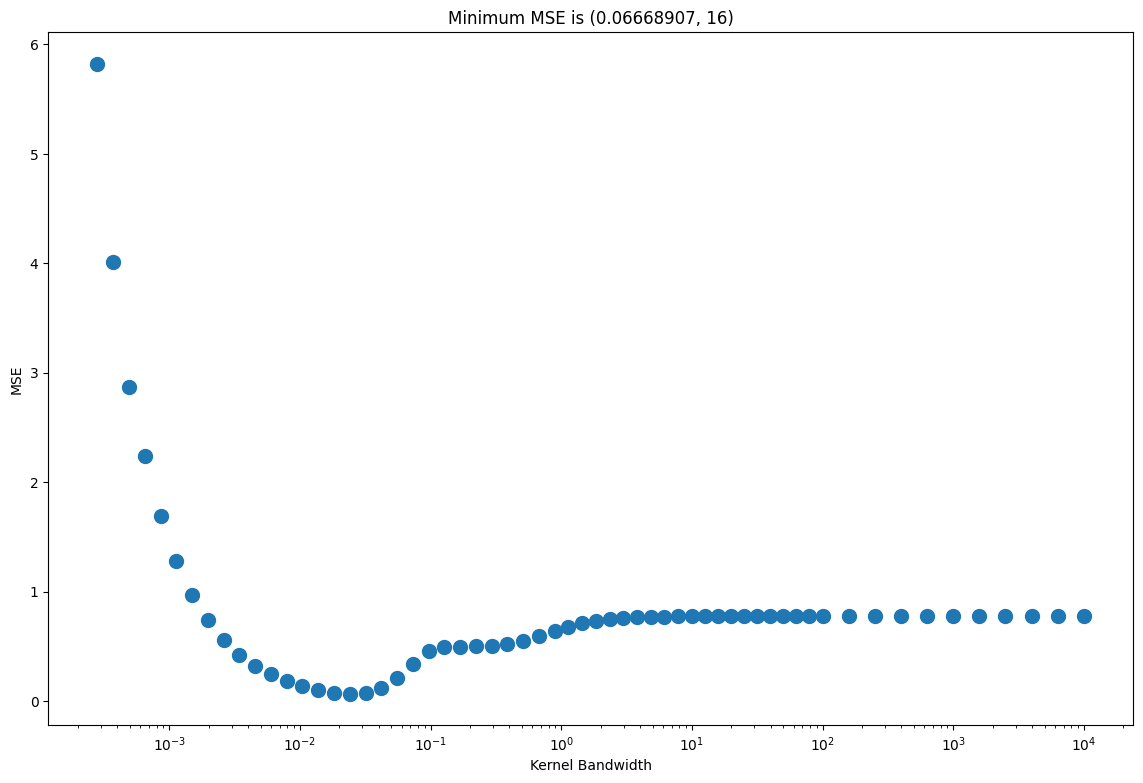

In [10]:
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_ylabel("MSE")
ax.set_xlabel("Kernel Bandwidth")
ax.set_title(f"Minimum MSE is {mses.iloc[np.argmin(mses.mse), 1], np.argmin(mses.mse)}")

In [11]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.nanmean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_rmse)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Nadaraya Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/QuadSinHFLessData/IIDNadaraya_{config.ndims}DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw} for {config.forcing_const}FConst\n")

In [12]:
from utils.resource_logger import wallclock_and_system_metrics
data = wallclock_and_system_metrics(config.nadaraya_resource_logging_path, inclusive=False)
data

FileNotFoundError: [Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/resource_logging/trained_rec_ST_1000FTh_PM_MLP_2LFac_NSTgtNFMReg_fQuadSinHF_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_05a_004b_250c_MLP_H4_CUp20_tl110.json.json'